# Pet breed detection

Problem: My neighborhood has a problem with stray pets. When they escape they can be a danger to themselves and others. Residents post images from their Nest cameras but we don't have an effective way to identify or notify pet owners.

Solution: This is part of a solution I presented to the Strawberry Hill neighborhood association. Working with Wyandotte County Animal Control and their pet registration database, my proposal is to expose an API allowing residents to post their images to a neighborhood page where they can be processed immediately against potential registered matches.

Goal: fine-tune a pre-trained model on a dataset exclusively of cats and dogs.

Dataset: [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)

Base models:

- [AlexNet](https://pytorch.org/vision/stable/models/alexnet)
- [ResNet](https://pytorch.org/vision/stable/models/resnet.html)
- [MobileNet](https://pytorch.org/vision/stable/models/mobilenetv2)

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import copy
import os
import shutil

In [21]:
# This notebook presumes there is an adjacent directory called 'images' that contains the dataset as downloaded from https://www.robots.ox.ac.uk/~vgg/data/pets/

# Create a new directory structure
root_dir = 'images'
organized_dir = 'organized_images'

if os.path.exists(organized_dir):
    shutil.rmtree(organized_dir)
os.makedirs(organized_dir)

# Organize the images into class folders
for filename in os.listdir(root_dir):
    if filename.endswith('.jpg'):
        class_name = '_'.join(filename.split('_')[:-1])
        class_dir = os.path.join(organized_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        shutil.copy(os.path.join(root_dir, filename), os.path.join(class_dir, filename))

print("Dataset organized successfully!")

Dataset organized successfully!


In [22]:
# Set device
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the dataset
data_dir = 'organized_images'
dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply respective transformations
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = dataset.classes

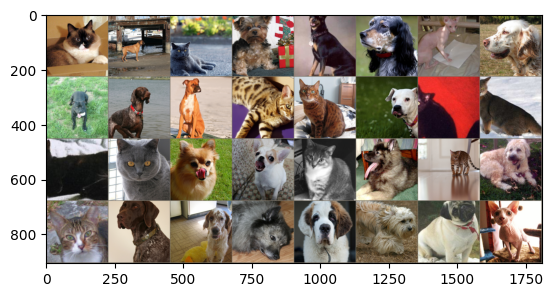

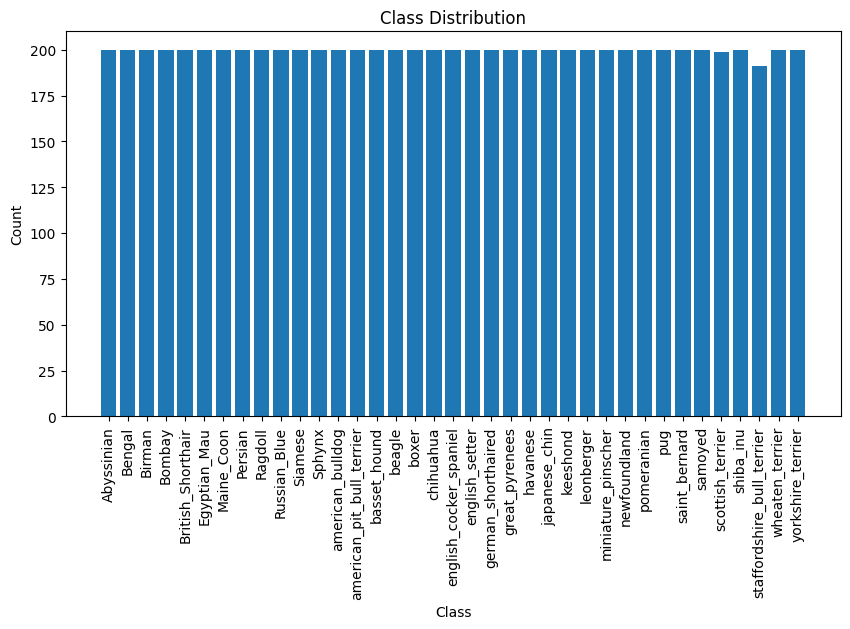

In [23]:
# Visualize a few images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = make_grid(inputs)
imshow(out)

# Plot the distribution of the classes
class_count = {}
for _, label in dataset:
    class_name = class_names[label]
    if class_name not in class_count:
        class_count[class_name] = 0
    class_count[class_name] += 1

plt.figure(figsize=(10, 5))
plt.bar(class_count.keys(), class_count.values())
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
# Modify the ResNet18 model
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, len(class_names))
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.fc.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/9
----------
train Loss: 1.2064 Acc: 0.6704
val Loss: 0.5289 Acc: 0.8241
Epoch 1/9
----------
train Loss: 0.4558 Acc: 0.8568
val Loss: 0.3932 Acc: 0.8721
Epoch 2/9
----------
train Loss: 0.3682 Acc: 0.8753
val Loss: 0.3670 Acc: 0.8755
Epoch 3/9
----------
train Loss: 0.3169 Acc: 0.8970
val Loss: 0.3556 Acc: 0.8836
Epoch 4/9
----------
train Loss: 0.2828 Acc: 0.9061
val Loss: 0.3308 Acc: 0.8917
Epoch 5/9
----------
train Loss: 0.2309 Acc: 0.9248
val Loss: 0.3508 Acc: 0.8890
Epoch 6/9
----------
train Loss: 0.2185 Acc: 0.9262
val Loss: 0.3854 Acc: 0.8714
Epoch 7/9
----------
train Loss: 0.1429 Acc: 0.9559
val Loss: 0.3022 Acc: 0.9019
Epoch 8/9
----------
train Loss: 0.1245 Acc: 0.9592
val Loss: 0.3103 Acc: 0.8978
Epoch 9/9
----------
train Loss: 0.1216 Acc: 0.9625
val Loss: 0.3107 Acc: 0.9026


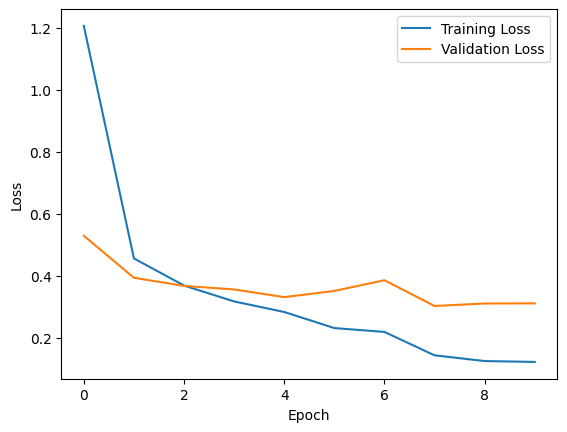

In [25]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # save the new best weights to a file with a timestamp
                torch.save(best_model_wts, f'best_model_{epoch}_{best_acc}.pth')


    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

model_ft, train_loss, val_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# Plot training and validation loss curves
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# Evaluate the model on the test set
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

                            precision    recall  f1-score   support

                Abyssinian       0.78      0.88      0.82        16
                    Bengal       0.90      0.90      0.90        20
                    Birman       0.75      0.63      0.69        19
                    Bombay       0.85      0.94      0.89        18
         British_Shorthair       0.94      0.77      0.85        22
              Egyptian_Mau       0.89      0.85      0.87        20
                Maine_Coon       0.90      0.79      0.84        24
                   Persian       0.93      1.00      0.96        26
                   Ragdoll       0.65      0.77      0.71        22
              Russian_Blue       0.83      0.83      0.83        24
                   Siamese       0.92      1.00      0.96        11
                    Sphynx       0.96      0.96      0.96        28
          american_bulldog       0.73      0.79      0.76        14
 american_pit_bull_terrier       1.00      0.80

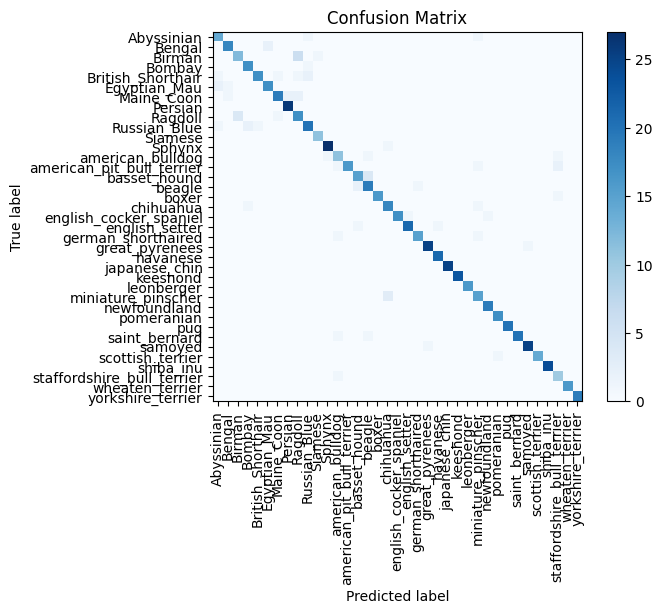

In [27]:
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation = 90)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
